In [1]:
# https://github.com/GoogleCloudPlatform/cloudml-samples/blob/master/notebooks/tensorflow/getting-started-keras.ipynb

## Import libraries and define constants

In [2]:
import os
from six.moves import urllib
import tempfile

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers

# Examine software versions
print(__import__('sys').version)
print(tf.__version__)
print(tf.keras.__version__)

3.7.5 (default, Oct 25 2019, 10:52:18) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
2.0.0
2.2.4-tf


Then, define some useful constants:

Information for downloading training and evaluation data
Information required for Pandas to interpret the data and convert categorical fields into numeric features
Hyperparameters for training, such as learning rate and batch size

In [3]:
### For downloading data ###

# Storage directory
DATA_DIR = os.path.join(os.getcwd(), 'census_data')

# Download options.
DATA_URL = 'https://storage.googleapis.com/cloud-samples-data/ai-platform' \
           '/census/data'
TRAINING_FILE = 'adult.data.csv'
EVAL_FILE = 'adult.test.csv'
TRAINING_URL = '%s/%s' % (DATA_URL, TRAINING_FILE)
EVAL_URL = '%s/%s' % (DATA_URL, EVAL_FILE)

### For interpreting data ###

# These are the features in the dataset.
# Dataset information: https://archive.ics.uci.edu/ml/datasets/census+income
_CSV_COLUMNS = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'gender',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
    'income_bracket'
]

_CATEGORICAL_TYPES = {
    'workclass': pd.api.types.CategoricalDtype(categories=[
        'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc',
        'Self-emp-not-inc', 'State-gov', 'Without-pay'
    ]),
    'marital_status': pd.api.types.CategoricalDtype(categories=[
        'Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
        'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'
    ]),
    'occupation': pd.api.types.CategoricalDtype([
        'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
        'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
        'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv',
        'Sales', 'Tech-support', 'Transport-moving'
    ]),
    'relationship': pd.api.types.CategoricalDtype(categories=[
        'Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried',
        'Wife'
    ]),
    'race': pd.api.types.CategoricalDtype(categories=[
        'Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White'
    ]),
    'native_country': pd.api.types.CategoricalDtype(categories=[
        'Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic',
        'Ecuador', 'El-Salvador', 'England', 'France', 'Germany', 'Greece',
        'Guatemala', 'Haiti', 'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary',
        'India', 'Iran', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Laos', 'Mexico',
        'Nicaragua', 'Outlying-US(Guam-USVI-etc)', 'Peru', 'Philippines', 'Poland',
        'Portugal', 'Puerto-Rico', 'Scotland', 'South', 'Taiwan', 'Thailand',
        'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia'
    ]),
    'income_bracket': pd.api.types.CategoricalDtype(categories=[
        '<=50K', '>50K'
    ])
}

# This is the label (target) we want to predict.
_LABEL_COLUMN = 'income_bracket'

### Hyperparameters for training ###

# This the training batch size
BATCH_SIZE = 128

# This is the number of epochs (passes over the full training data)
NUM_EPOCHS = 20

# Define learning rate.
LEARNING_RATE = .01

## Download and preprocess data

Download the data
Next, define functions to download training and evaluation data. These functions also fix minor irregularities in the data's formatting.

In [4]:
def _download_and_clean_file(filename, url):
    """Downloads data from url, and makes changes to match the CSV format.
  
    The CSVs may use spaces after the comma delimters (non-standard) or include
    rows which do not represent well-formed examples. This function strips out
    some of these problems.
  
    Args:
      filename: filename to save url to
      url: URL of resource to download
    """
    temp_file, _ = urllib.request.urlretrieve(url)
    with tf.compat.v1.gfile.Open(temp_file, 'r') as temp_file_object:
        with tf.compat.v1.gfile.Open(filename, 'w') as file_object:
            for line in temp_file_object:
                line = line.strip()
                line = line.replace(', ', ',')
                if not line or ',' not in line:
                    continue
                if line[-1] == '.':
                    line = line[:-1]
                line += '\n'
                file_object.write(line)
    tf.io.gfile.remove(temp_file)


def download(data_dir):
    """Downloads census data if it is not already present.
  
    Args:
      data_dir: directory where we will access/save the census data
    """
    tf.io.gfile.makedirs(data_dir)

    training_file_path = os.path.join(data_dir, TRAINING_FILE)
    if not tf.io.gfile.exists(training_file_path):
        _download_and_clean_file(training_file_path, TRAINING_URL)

    eval_file_path = os.path.join(data_dir, EVAL_FILE)
    if not tf.io.gfile.exists(eval_file_path):
        _download_and_clean_file(eval_file_path, EVAL_URL)

    return training_file_path, eval_file_path

Use those functions to download the data for training and verify that you have CSV files for training and evaluation:

In [5]:
training_file_path, eval_file_path = download(DATA_DIR)

# You should see 2 files: adult.data.csv and adult.test.csv
!ls -l $DATA_DIR

total 10312
-rw-r--r--  1 k.ho  staff  3518450 Dec 26 15:25 adult.data.csv
-rw-r--r--  1 k.ho  staff  1758573 Dec 26 15:25 adult.test.csv


Next, load these files using Pandas and examine the data:

In [6]:
# This census data uses the value '?' for fields (column) that are missing data. 
# We use na_values to find ? and set it to NaN values.
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

train_df = pd.read_csv(training_file_path, names=_CSV_COLUMNS, na_values='?')
eval_df = pd.read_csv(eval_file_path, names=_CSV_COLUMNS, na_values='?')

# Here's what the data looks like before we preprocess the data.
train_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocess the data

The first preprocessing step removes certain features from the data and converts categorical features to numerical values for use with Keras.

In [7]:
UNUSED_COLUMNS = ['fnlwgt', 'education', 'gender']


def preprocess(dataframe):
    """Converts categorical features to numeric. Removes unused columns.
  
    Args:
      dataframe: Pandas dataframe with raw data
  
    Returns:
      Dataframe with preprocessed data
    """
    dataframe = dataframe.drop(columns=UNUSED_COLUMNS)

    # Convert integer valued (numeric) columns to floating point
    numeric_columns = dataframe.select_dtypes(['int64']).columns
    dataframe[numeric_columns] = dataframe[numeric_columns].astype('float32')

    # Convert categorical columns to numeric
    cat_columns = dataframe.select_dtypes(['object']).columns
    dataframe[cat_columns] = dataframe[cat_columns].apply(lambda x: x.astype(
        _CATEGORICAL_TYPES[x.name]))
    dataframe[cat_columns] = dataframe[cat_columns].apply(lambda x: x.cat.codes)
    return dataframe


prepped_train_df = preprocess(train_df)
prepped_eval_df = preprocess(eval_df)

Run the following cell to see how preprocessing changed the data. Notice in particular that income_bracket, the label that you're training the model to predict, has changed from <=50K and >50K to 0 and 1:

In [8]:
prepped_train_df.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39.0,6,13.0,4,0,1,4,2174.0,0.0,40.0,38,0
1,50.0,5,13.0,2,3,0,4,0.0,0.0,13.0,38,0
2,38.0,3,9.0,0,5,1,4,0.0,0.0,40.0,38,0
3,53.0,3,7.0,2,5,0,2,0.0,0.0,40.0,38,0
4,28.0,3,13.0,2,9,5,2,0.0,0.0,40.0,4,0


Next, separate the data into features ("x") and labels ("y"), and reshape the label arrays into a format for use with tf.data.Dataset later:

In [9]:
# Split train and test data with labels.
# The pop() method will extract (copy) and remove the label column from the dataframe
train_x, train_y = prepped_train_df, prepped_train_df.pop(_LABEL_COLUMN)
eval_x, eval_y = prepped_eval_df, prepped_eval_df.pop(_LABEL_COLUMN)

# Reshape label columns for use with tf.data.Dataset
train_y = np.asarray(train_y).astype('float32').reshape((-1, 1))
eval_y = np.asarray(eval_y).astype('float32').reshape((-1, 1))

Scaling training data so each numerical feature column has a mean of 0 and a standard deviation of 1 can improve your model.

In a production system, you may want to save the means and standard deviations from your training set and use them to perform an identical transformation on test data at prediction time. For convenience in this exercise, temporarily combine the training and evaluation data to scale all of them:

In [10]:
def standardize(dataframe):
    """Scales numerical columns using their means and standard deviation to get
    z-scores: the mean of each numerical column becomes 0, and the standard
    deviation becomes 1. This can help the model converge during training.
  
    Args:
      dataframe: Pandas dataframe
  
    Returns:
      Input dataframe with the numerical columns scaled to z-scores
    """
    dtypes = list(zip(dataframe.dtypes.index, map(str, dataframe.dtypes)))
    # Normalize numeric columns.
    for column, dtype in dtypes:
        if dtype == 'float32':
            dataframe[column] -= dataframe[column].mean()
            dataframe[column] /= dataframe[column].std()
    return dataframe


# Join train_x and eval_x to normalize on overall means and standard
# deviations. Then separate them again.
all_x = pd.concat([train_x, eval_x], keys=['train', 'eval'])
all_x = standardize(all_x)
train_x, eval_x = all_x.xs('train'), all_x.xs('eval')

Finally, examine some of your fully preprocessed training data:

In [11]:
# Verify dataset features
# Note how only the numeric fields (not categorical) have been standardized
train_x.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country
0,0.025997,6,1.136580,4,0,1,4,0.146933,-0.217132,-0.034039,38
1,0.828278,5,1.136580,2,3,0,4,-0.144792,-0.217132,-2.212964,38
2,-0.046938,3,-0.419265,0,5,1,4,-0.144792,-0.217132,-0.034039,38
3,1.047082,3,-1.197188,2,5,0,2,-0.144792,-0.217132,-0.034039,38
4,-0.776285,3,1.136580,2,9,5,2,-0.144792,-0.217132,-0.034039,4


## Design and train the model

### Create training and validation datasets

Create an input function to convert features and labels into a tf.data.Dataset for training or evaluation:

In [12]:
def input_fn(features, labels, shuffle, num_epochs, batch_size):
    """Generates an input function to be used for model training.
  
    Args:
      features: numpy array of features used for training or inference
      labels: numpy array of labels for each example
      shuffle: boolean for whether to shuffle the data or not (set True for
        training, False for evaluation)
      num_epochs: number of epochs to provide the data for
      batch_size: batch size for training
  
    Returns:
      A tf.data.Dataset that can provide data to the Keras model for training or
        evaluation
    """
    if labels is None:
        inputs = features
    else:
        inputs = (features, labels)
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(features))

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(batch_size)
    return dataset

Next, create these training and evaluation datasets.Use the NUM_EPOCHS and BATCH_SIZE hyperparameters defined previously to define how the training dataset provides examples to the model during training. Set up the validation dataset to provide all its examples in one batch, for a single validation step at the end of each training epoch.

In [13]:
# Pass a numpy array by using DataFrame.values
training_dataset = input_fn(features=train_x.values, 
                    labels=train_y, 
                    shuffle=True, 
                    num_epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE)

num_eval_examples = eval_x.shape[0]

# Pass a numpy array by using DataFrame.values
validation_dataset = input_fn(features=eval_x.values, 
                    labels=eval_y, 
                    shuffle=False, 
                    num_epochs=NUM_EPOCHS, 
                    batch_size=num_eval_examples)

## Design a Keras Model

Design your neural network using the Keras Sequential API (https://www.tensorflow.org/guide/keras#sequential_model).

This deep neural network (DNN) has several hidden layers, and the last layer uses a sigmoid activation function to output a value between 0 and 1:

The input layer has 100 units using the ReLU activation function.
The hidden layer has 75 units using the ReLU activation function.
The hidden layer has 50 units using the ReLU activation function.
The hidden layer has 25 units using the ReLU activation function.
The output layer has 1 units using a sigmoid activation function.
The optimizer uses the binary cross-entropy loss function, which is appropriate for a binary classification problem like this one.
Feel free to change these layers to try to improve the model:

In [22]:
def create_keras_model(input_dim, learning_rate):
    """Creates Keras Model for Binary Classification.
  
    Args:
      input_dim: How many features the input has
      learning_rate: Learning rate for training
  
    Returns:
      The compiled Keras model (still needs to be trained)
    """
    Dense = tf.keras.layers.Dense
    Dropout = tf.keras.layers.Dropout
    model = tf.keras.Sequential(
      [
          Dense(100, 
                kernel_regularizer=regularizers.l2(0.0001),
                activation=tf.nn.relu, 
                kernel_initializer='uniform',
                input_shape=(input_dim,)),
          Dropout(0.5),
          Dense(75, 
                kernel_regularizer=regularizers.l2(0.0001),
                activation=tf.nn.relu),
          Dropout(0.5),
          Dense(50, 
                kernel_regularizer=regularizers.l2(0.0001),
                activation=tf.nn.relu),
          Dense(25, 
                kernel_regularizer=regularizers.l2(0.0001),
                activation=tf.nn.relu),
          Dense(1, activation=tf.nn.sigmoid)
      ])
    # Custom Optimizer:
    # https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer
    optimizer = tf.keras.optimizers.RMSprop(
        lr=learning_rate)

    # Compile Keras model
    model.compile(
        loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Next, create the Keras model object and examine its structure:

In [23]:
num_train_examples, input_dim = train_x.shape
print('Number of features: {}'.format(input_dim))
print('Number of examples: {}'.format(num_train_examples))

keras_model = create_keras_model(
    input_dim=input_dim,
    learning_rate=LEARNING_RATE)

# Take a detailed look inside the model
keras_model.summary()

Number of features: 11
Number of examples: 32561
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               1200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 75)                7575      
_________________________________________________________________
dropout_3 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_8 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense

## Train and evaluate the model

Define a learning rate decay to encourage model paramaters to make smaller changes as training goes on:

In [24]:
# Setup Learning Rate decay.
lr_decay_cb = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE + 0.02 * (0.5 ** (1 + epoch)),
    verbose=True)

# Setup TensorBoard callback.
# tensorboard_cb = tf.keras.callbacks.TensorBoard(
#       os.path.join(JOB_DIR, 'keras_tensorboard'),
#       histogram_freq=1)

Finally, train the model. Provide the appropriate steps_per_epoch for the model to train on the entire training dataset (with BATCH_SIZE examples per step) during each epoch. And instruct the model to calculate validation accuracy with one big validation batch at the end of each epoch.

In [25]:
history = keras_model.fit(training_dataset, 
                          epochs=NUM_EPOCHS, 
                          steps_per_epoch=int(num_train_examples/BATCH_SIZE), 
                          validation_data=validation_dataset, 
                          validation_steps=1, 
                          callbacks=[lr_decay_cb, 
#                                      tensorboard_cb],
                          ],
                          verbose=1)

Train for 254 steps, validate for 1 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.02.
Epoch 1/20
254/254 [==============================] - 4s 16ms/step - loss: 0.5670 - accuracy: 0.7721 - val_loss: 0.4206 - val_accuracy: 0.7968

Epoch 00002: LearningRateScheduler reducing learning rate to 0.015.
Epoch 2/20
254/254 [==============================] - 2s 9ms/step - loss: 0.4307 - accuracy: 0.8061 - val_loss: 0.3793 - val_accuracy: 0.8372

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 3/20
254/254 [==============================] - 3s 10ms/step - loss: 0.4051 - accuracy: 0.8202 - val_loss: 0.3718 - val_accuracy: 0.8396

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01125.
Epoch 4/20
254/254 [==============================] - 3s 10ms/step - loss: 0.3997 - accuracy: 0.8233 - val_loss: 0.3625 - val_accuracy: 0.8409

Epoch 00005: LearningRateScheduler reducing learning rate to 0.010625.
Epoch 5/20
254/254 [=================

## Visualize training and export the trained model

### Visualize training

Import matplotlib to visualize how the model learned over the training period.

In [26]:
! pip install matplotlib

from matplotlib import pyplot as plt

%matplotlib inline

Plot the model's loss (binary cross-entropy) and accuracy, as measured at the end of each training epoch:

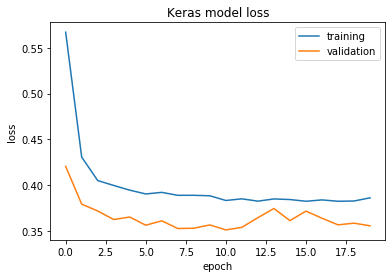

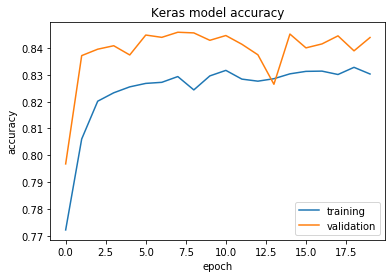

In [27]:
# Visualize History for Loss.
plt.title('Keras model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Visualize History for Accuracy.
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

Over time, loss decreases and accuracy increases. But do they converge to a stable level? Are there big differences between the training and validation metrics (a sign of overfitting)?

Learn about how to improve your machine learning model. Then, feel free to adjust hyperparameters or the model architecture and train again.

## Export the model for serving

Use tf.contrib.saved_model.save_keras_model to export a TensorFlow SavedModel directory. This is the format that Cloud AI Platform requires when you create a model version resource.

Since not all optimizers can be exported to the SavedModel format, you may see warnings during the export process. As long you successfully export a serving graph, AI Platform can used the SavedModel to serve predictions.

In [31]:
# Export the model to a local SavedModel directory 
export_dir = os.path.join(os.getcwd(), 'census_data_tensorflow_model_export')
export_path = tf.keras.models.save_model(keras_model, export_dir, save_format="tf")
print("Model exported to: ", export_path)

INFO:tensorflow:Assets written to: /Users/k.ho/census_data_tensorflow_model_export/assets
Model exported to:  None
